# 集成学习

> adaBoost

adaptive boosting 适应性增强算法。

## load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# iris 前100行(4类)，前2列
def loadDataSet():
    dt=pd.read_csv('../data/iris_data/iris.csv', index_col=0)
    return dt.iloc[0:100,:]
iris=loadDataSet()
print(iris.shape) #100 5
print(iris.head())
iris.tail()

(100, 5)
   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
96,5.7,3.0,4.2,1.2,versicolor
97,5.7,2.9,4.2,1.3,versicolor
98,6.2,2.9,4.3,1.3,versicolor
99,5.1,2.5,3.0,1.1,versicolor
100,5.7,2.8,4.1,1.3,versicolor


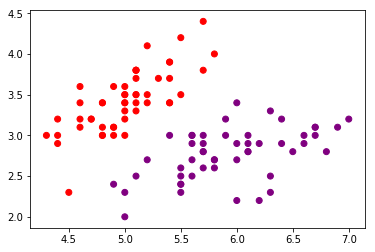

In [3]:
colors=[]
for item in iris['Species']:
    if item=='setosa':
        colors.append('red')
    elif item=="virginica":
        colors.append('orange')
    else:
        colors.append('purple')
import matplotlib.pyplot as plt
plt.scatter(iris['Sepal.Length'], iris['Sepal.Width'], color=colors )
plt.show()

In [4]:
# 标签要数字化
def np2Array(npArr):
    arr=[]
    tags=[]
    for i in range(npArr.shape[0]):
        arr.append([npArr.iloc[i,0], npArr.iloc[i,1]
                   # , npArr.iloc[i,2], npArr.iloc[i,3]
                   ])
        if "versicolor"==npArr.iloc[i,-1]:
            tags.append(-1.0)
        else:
            tags.append(1.0)
    return arr,tags
dataArr, dataTags=np2Array(iris)

print(dataArr[0:10])
print(dataTags[0:10])
dataTags[90:100] #标签使用1和-1

[[5.1, 3.5], [4.9, 3.0], [4.7, 3.2], [4.6, 3.1], [5.0, 3.6], [5.4, 3.9], [4.6, 3.4], [5.0, 3.4], [4.4, 2.9], [4.9, 3.1]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

## 单层决策树生成函数

In [5]:
# 简单分类器预测
# 输入: 数据矩阵，按照第几列分类，阈值，符号
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArr=np.ones( (np.shape(dataMatrix)[0], 1) ) #m行1列
    if threshIneq == "lt":
        retArr[dataMatrix[:,dimen] <= threshVal ]=-1.0
    else:
        retArr[dataMatrix[:,dimen] > threshVal ]=1.0
    return retArr;

# 样本权重矩阵D
def buildStump(dataArr, classLabels, D, debug=False):
    dataMatrix=np.mat(dataArr)     #150x2
    labelMat=np.mat(classLabels).T #100x1
    m,n=np.shape(dataMatrix)
    numSteps=50.0 #极值分几份
    bestStump={}
    bestClasEst=np.mat(np.zeros( (m,1) ))
    minError=np.inf
    # 循环每一列，找最佳分类位
    for i in range(n):
        # 找该列的最值
        rangeMin=dataMatrix[:, i].min();
        rangeMax=dataMatrix[:, i].max();
        stepSize=(rangeMax-rangeMin)/numSteps #步长
        # 每个步长，首尾各加1个
        for j in range(-1, int(numSteps)+1):
            # 两个不等式
            for inequal in ['lt', 'gt']:
                threshVal=rangeMin + j*stepSize
                predictedVals=stumpClassify(dataMatrix, i, threshVal, inequal) #进行简单预测
                # 对预测错的样本1；正确的0
                errArr=np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat]=0
                #样本权重和错误的交互
                weightedError=D.T*errArr;
                
                #
                if debug:
                    print("split: dim %d, thresh %.2f, thresh ineqal:%s, the weighted error is %.3f" %\
                     (i, threshVal, inequal, weightedError))
                    #
                    print('>>', i, j,inequal, minError) #-----> debug
                
                if weightedError < minError:
                    minError=weightedError
                    bestClasEst=predictedVals.copy()
                    bestStump['dim']=i
                    bestStump['thresh']=threshVal
                    bestStump['ineq']=inequal
    return bestStump, minError.tolist()[0][0], bestClasEst

# test
D=np.mat(np.ones( (100,1) ))/100    #初始化样本权重，样本权重和为1
a1,a2,a3=buildStump(dataArr, dataTags, D)
print(a1, a2, a3[0:10])

{'dim': 1, 'thresh': 3.008, 'ineq': 'lt'} 0.16 [[ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]


### 分类器权重函数 y=0.5*ln(1/x -1)

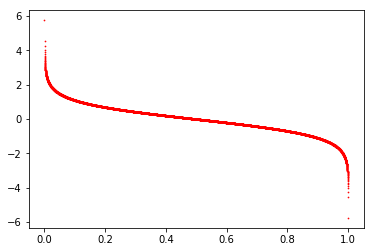

In [6]:
small=1e-5
x=np.linspace(0+small,1-small,10000)
y=0.5*np.log(1/x -1)
#print(x,y)
plt.scatter(x, y, s=0.5, c='red')
plt.show()

## 基于单层决策树的 adaBoost训练过程

In [25]:
# DS 代表单层决策树 decision stump
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr=[]
    m=np.shape(dataArr)[0]
    D=np.mat(np.ones( (m,1) )/m) #初始化样本权重，和为1
    aggClassEst=np.mat(np.zeros( (m,1) ))
    for i in range(numIt):
        # 迭代一次，获取一个全局最优弱分类器，依赖于样本权重矩阵D
        bestStump, error, classEst=buildStump(dataArr, classLabels, D)
        print('='*20,' i=',i, '; error=', error, '\n', "D", D.T)
        alpha=float(0.5*np.log( (1.0-error)/max(error, 1e-16) ) ) #保证分母不为0
        bestStump['alpha']=alpha       #alpha是分类器权重，错误率越小，权重越高
        #bestStump['error']=error.tolist()[0][0]
        weakClassArr.append(bestStump)
        print('ClassEst', classEst.T)
        
        #(1) 为下次迭代计算样本权重D:
        # 正确分类，样本权重降 乘以exp(-alpha); 否则升 乘以exp(alpha)
        expon=np.multiply(-1*alpha*np.mat(classLabels).T, classEst) #就是alpha，其他是确定符号。
        D=np.multiply(D, np.exp(expon))
        D=D/D.sum()
        
        #(2) 错误率累加计算: 分类器权重alpha * 分类器预测结果
        aggClassEst += alpha*classEst
        print('aggClassEst: ', aggClassEst.T)
        aggErrors = np.multiply( np.sign(aggClassEst)!=np.mat(classLabels).T, np.ones( (m,1) ) )
        errorRate = aggErrors.sum()/m
        
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0: break;
    return weakClassArr

# test
rs=adaBoostTrainDS(dataArr, dataTags,numIt=40)

====================  i= 0 ; error= 0.16 
 D [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01]]
ClassEst [[ 1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.
  -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
aggClassEst:  

====================  i= 11 ; error= 0.46443871659944347 
 D [[0.00142245 0.03846729 0.0073271  0.0073271  0.00142245 0.00142245
  0.00388887 0.00388887 0.03846729 0.0073271  0.00142245 0.00388887
  0.03846729 0.03846729 0.00142245 0.00142245 0.00142245 0.00142245
  0.00142245 0.00142245 0.00388887 0.00142245 0.00142245 0.0073271
  0.00388887 0.03846729 0.00388887 0.00142245 0.00388887 0.0073271
  0.0073271  0.00388887 0.00142245 0.00142245 0.0073271  0.0073271
  0.00142245 0.00142245 0.03846729 0.00388887 0.00142245 0.07956969
  0.0073271  0.00142245 0.00142245 0.03846729 0.00142245 0.0073271
  0.00142245 0.0073271  0.035839   0.035839   0.035839   0.0033002
  0.0033002  0.0033002  0.035839   0.0033002  0.00682648 0.0033002
  0.00142245 0.00682648 0.00142245 0.00682648 0.00682648 0.035839
  0.00682648 0.0033002  0.00142245 0.0033002  0.035839   0.0033002
  0.0033002  0.0033002  0.00682648 0.00682648 0.0033002  0.00682648
  0.00682648 0.0033002  0.0033002  0.0033002  0.0033002  0.00330

====================  i= 23 ; error= 0.4808136802750806 
 D [[0.00076745 0.03982355 0.00758544 0.00758544 0.00076745 0.00076745
  0.00402598 0.00402598 0.03982355 0.00758544 0.00076745 0.00402598
  0.03982355 0.03982355 0.00076745 0.00076745 0.00076745 0.00076745
  0.00076745 0.00076745 0.00402598 0.00076745 0.00076745 0.00758544
  0.00402598 0.03982355 0.00402598 0.00076745 0.00402598 0.00758544
  0.00758544 0.00402598 0.00076745 0.00076745 0.00758544 0.00758544
  0.00076745 0.00076745 0.03982355 0.00402598 0.00076745 0.08237512
  0.00758544 0.00076745 0.00076745 0.03982355 0.00076745 0.00758544
  0.00076745 0.00758544 0.035839   0.035839   0.035839   0.0033002
  0.0033002  0.0033002  0.035839   0.0033002  0.00682648 0.0033002
  0.00076745 0.00682648 0.00076745 0.00682648 0.00682648 0.035839
  0.00682648 0.0033002  0.00076745 0.0033002  0.035839   0.0033002
  0.0033002  0.0033002  0.00682648 0.00682648 0.0033002  0.00682648
  0.00682648 0.0033002  0.0033002  0.0033002  0.0033002  0.00

====================  i= 35 ; error= 0.48686292923417085 
 D [[0.00052548 0.04032458 0.00768087 0.00768087 0.00052548 0.00052548
  0.00407664 0.00407664 0.04032458 0.00768087 0.00052548 0.00407664
  0.04032458 0.04032458 0.00052548 0.00052548 0.00052548 0.00052548
  0.00052548 0.00052548 0.00407664 0.00052548 0.00052548 0.00768087
  0.00407664 0.04032458 0.00407664 0.00052548 0.00407664 0.00768087
  0.00768087 0.00407664 0.00052548 0.00052548 0.00768087 0.00768087
  0.00052548 0.00052548 0.04032458 0.00407664 0.00052548 0.08341151
  0.00768087 0.00052548 0.00052548 0.04032458 0.00052548 0.00768087
  0.00052548 0.00768087 0.035839   0.035839   0.035839   0.0033002
  0.0033002  0.0033002  0.035839   0.0033002  0.00682648 0.0033002
  0.00052548 0.00682648 0.00052548 0.00682648 0.00682648 0.035839
  0.00682648 0.0033002  0.00052548 0.0033002  0.035839   0.0033002
  0.0033002  0.0033002  0.00682648 0.00682648 0.0033002  0.00682648
  0.00682648 0.0033002  0.0033002  0.0033002  0.0033002  0.0

In [26]:
rs

[{'alpha': 0.8291140383017662, 'dim': 1, 'ineq': 'lt', 'thresh': 3.008},
 {'alpha': 0.3167304797547354,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.3440000000000003},
 {'alpha': 0.36341248251629465,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 2.8160000000000003},
 {'alpha': 0.19532190264860042,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.4400000000000004},
 {'alpha': 0.14259706797816468, 'dim': 1, 'ineq': 'lt', 'thresh': 2.24},
 {'alpha': 0.12470836108440413,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.4400000000000004},
 {'alpha': 0.1108239064341755, 'dim': 1, 'ineq': 'lt', 'thresh': 2.24},
 {'alpha': 0.09973059327455619,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.4400000000000004},
 {'alpha': 0.09066157673741573, 'dim': 1, 'ineq': 'lt', 'thresh': 2.24},
 {'alpha': 0.08310793727100553,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.4400000000000004},
 {'alpha': 0.07671846190714693, 'dim': 1, 'ineq': 'lt', 'thresh': 2.24},
 {'alpha': 0.07124285468579544,
  'dim': 1,
  'ineq': 'lt',
  'thresh': 3.44000

## 效果总结不好

> 效果很不好，不知道啥原因

错了一半，像瞎猜的一样。

In [27]:
def adaClassify(datToClass, classifierArr, debug=False):
    dataMatrix=np.mat(datToClass)
    m=np.shape(dataMatrix)[0]
    aggClassEst=np.mat(np.zeros( (m,1) ))
    for i in range(len(classifierArr)):
        obj=classifierArr[i]
        classEst=stumpClassify(dataMatrix, obj['dim'], obj['thresh'], obj['ineq'])
        aggClassEst += obj['alpha']*classEst
        print(aggClassEst)
    return np.sign(aggClassEst)
# test
adaClassify([[5.1, 3.5]], rs, debug=True)

[[0.82911404]]
[[1.14584452]]
[[1.509257]]
[[1.7045789]]
[[1.84717597]]
[[1.97188433]]
[[2.08270824]]
[[2.18243883]]
[[2.27310041]]
[[2.35620835]]
[[2.43292681]]
[[2.50416966]]
[[2.57066753]]
[[2.63301378]]
[[2.69169689]]
[[2.74712384]]
[[2.79963731]]
[[2.84952853]]
[[2.89704712]]
[[2.94240864]]
[[2.98580054]]
[[3.02738685]]
[[3.06731191]]
[[3.1057034]]
[[3.14267483]]
[[3.17832755]]
[[3.21275242]]
[[3.24603124]]
[[3.27823788]]
[[3.30943929]]
[[3.33969634]]
[[3.36906453]]
[[3.39759461]]
[[3.4253331]]
[[3.45232275]]
[[3.47860294]]
[[3.50421002]]
[[3.52917762]]
[[3.5535369]]
[[3.5773168]]


matrix([[1.]])

In [29]:
TR=0
FR=0
for i in range(len(dataArr)):
    pred=adaClassify( dataArr[i], rs2)
    print('>>>>>>>>>>i=',i, dataArr[i],dataTags[i], '; pred=', pred, pred==dataTags[i])
    if pred==dataTags[i]:
        TR +=1
    else:
        FR +=1
print(TR, FR, TR/(TR+FR))

[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 0 [5.1, 3.5] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 1 [4.9, 3.0] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 2 [4.7, 3.2] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 3 [4.6, 3.1] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 4 [5.0, 3.6] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 5 [5.4, 3.9] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 6 [4.6, 3.4] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 7 [5.0, 3.4] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 8 [4.4, 2.9] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 9 [4.9, 3.1] 1.0 ; pred= [[1.]] [[ True]]


>>>>>>>>>>i= 94 [5.6, 2.7] -1.0 ; pred= [[1.]] [[False]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 95 [5.7, 3.0] -1.0 ; pred= [[1.]] [[False]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 96 [5.7, 2.9] -1.0 ; pred= [[1.]] [[False]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 97 [6.2, 2.9] -1.0 ; pred= [[1.]] [[False]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 98 [5.1, 2.5] -1.0 ; pred= [[1.]] [[False]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>>i= 99 [5.7, 2.8] -1.0 ; pred= [[1.]] [[False]]
50 50 0.5


# 带入例题的数据呢

In [9]:
def loadSimData():
    datMat=np.mat([
        [1,2.1],
        [1.5,1.6],
        [1.3,1],
        [1,1],
        [2,1]
    ])
    classLabels=[1.0,1.0,-1.0,-1.0,1.0]
    return datMat, classLabels
X,Y=loadSimData()
print(X,Y)

[[1.  2.1]
 [1.5 1.6]
 [1.3 1. ]
 [1.  1. ]
 [2.  1. ]] [1.0, 1.0, -1.0, -1.0, 1.0]


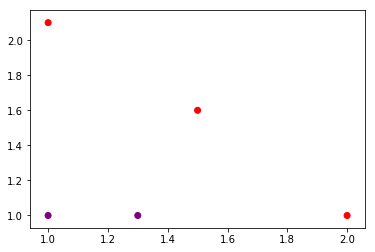

In [10]:
colors=[]
for item in Y:
    if item>0:
        colors.append('red')
    else:
        colors.append('purple')
#
x1=[]
x2=[]
for i in X:
    x1.append(i.tolist()[0][0])
    x2.append(i.tolist()[0][1])
    
import matplotlib.pyplot as plt
plt.scatter(x1, x2, color=colors )
plt.show()

In [11]:
rs2=adaBoostTrainDS(X, Y,numIt=200)

====================  i= 0 ; error= 0.2 
 D [[0.2 0.2 0.2 0.2 0.2]]
ClassEst [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

====================  i= 1 ; error= 0.12500000000000003 
 D [[0.5   0.125 0.125 0.125 0.125]]
ClassEst [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

====================  i= 2 ; error= 0.1428571428571429 
 D [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
ClassEst [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [12]:
rs2

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.98}]

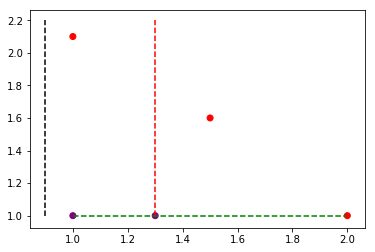

In [13]:
plt.scatter(x1, x2, color=colors )

plt.plot([1.3,1.3], [1,2.2], 'r--') #dim 0
plt.plot([1,2], [1,1], 'g--') #dim 1
plt.plot([0.9,0.9], [1,2.2], 'k--') #dim 0

plt.show()

## 验证

In [15]:
# test
adaClassify([ [0,0] ], rs2)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [30]:
adaClassify([ [5,5], [0,0] ], rs2)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

In [20]:
for i in range(len(X)):
    pred=adaClassify( X[i], rs2)
    print('>>>>>>>>>>',i, X[i],Y[i], '; pred=', pred, pred==Y[i])

[[-0.69314718]]
[[0.27980789]]
[[1.17568763]]
>>>>>>>>>> 0 [[1.  2.1]] 1.0 ; pred= [[1.]] [[ True]]
[[0.69314718]]
[[1.66610226]]
[[2.56198199]]
>>>>>>>>>> 1 [[1.5 1.6]] 1.0 ; pred= [[1.]] [[ True]]
[[-0.69314718]]
[[-1.66610226]]
[[-0.77022252]]
>>>>>>>>>> 2 [[1.3 1. ]] -1.0 ; pred= [[-1.]] [[ True]]
[[-0.69314718]]
[[-1.66610226]]
[[-0.77022252]]
>>>>>>>>>> 3 [[1. 1.]] -1.0 ; pred= [[-1.]] [[ True]]
[[0.69314718]]
[[-0.27980789]]
[[0.61607184]]
>>>>>>>>>> 4 [[2. 1.]] 1.0 ; pred= [[1.]] [[ True]]
